# Import library

In [1]:
# Import required packages
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

import datetime 
import matplotlib.dates as mdates

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


# Import data

In [2]:
from matplotlib import rcParams

plt.style.use('ggplot')
rcParams['figure.figsize'] = 16, 9
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 18
rcParams['axes.linewidth'] = 2

In [3]:
df = pd.read_csv('../input/steel-industry-energy-consumption/Steel_industry_data.csv')
# df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y %H:%M')
load = df['Usage_kWh']
time = df['date']


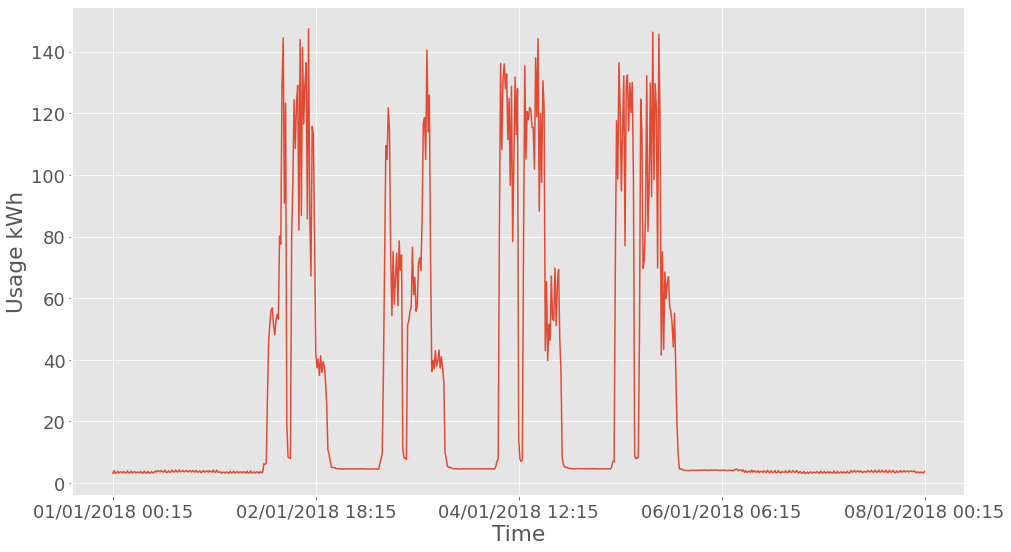

In [4]:
plt.plot(time[:673], load[:673])
plt.xticks(np.arange(0, 673, step = 168))
plt.xlabel('Time')
plt.ylabel('Usage kWh')
plt.savefig('UsageWeek.png')
plt.show()

# Cleaning data

In [5]:
#replace 0 value with the minimum value except 0
second_min = min(load[load != 0])
load[load == 0] = second_min
display(load[load == 0])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Series([], Name: Usage_kWh, dtype: float64)

# some explanatory data here

In [6]:
display(load.describe())

count    35040.000000
mean        27.386962
std         33.444325
min          2.450000
25%          3.200000
50%          4.570000
75%         51.237500
max        157.180000
Name: Usage_kWh, dtype: float64

# Spliting data (70:30)

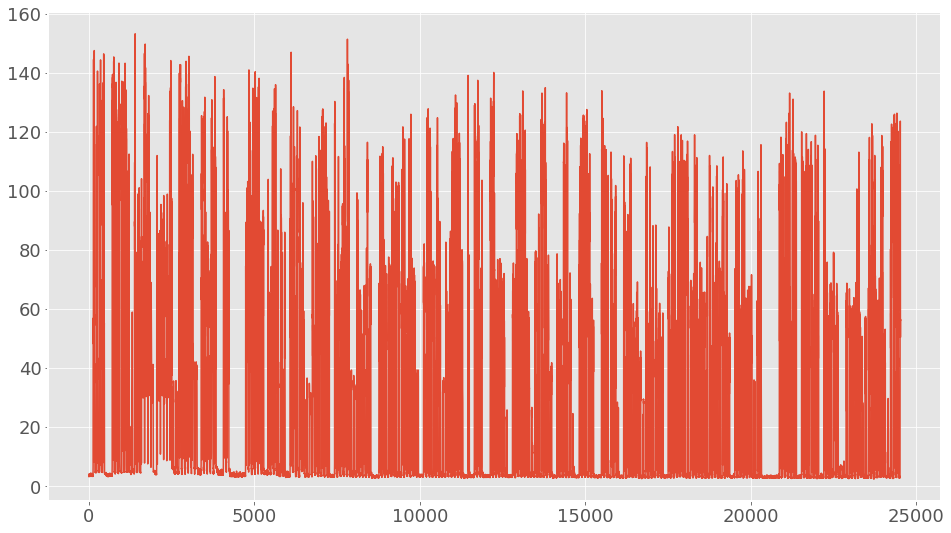

In [7]:
train = load[:int(len(load)*0.7)]
test = load[int(len(load)*0.7):]
plt.plot(train)
plt.show()

<Figure size 1152x648 with 0 Axes>

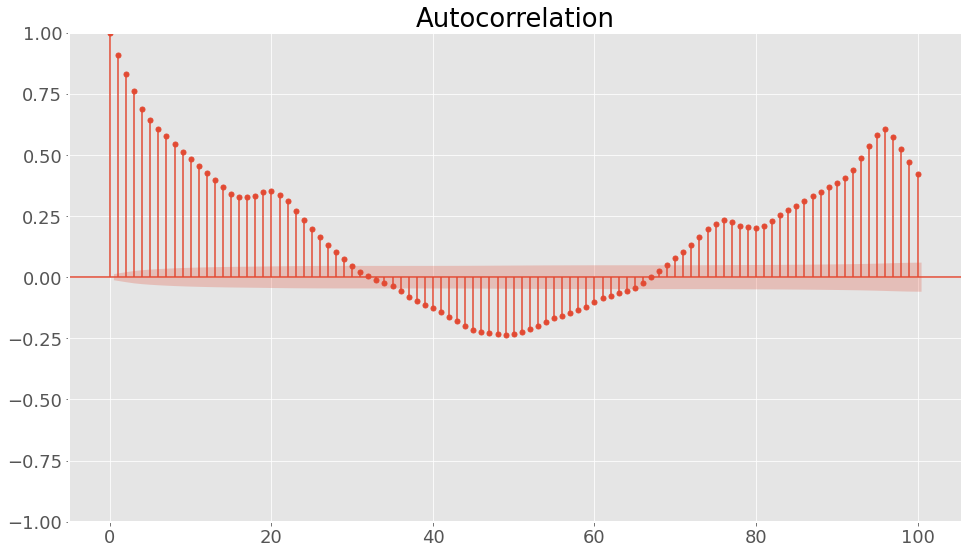

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


<Figure size 1152x648 with 0 Axes>

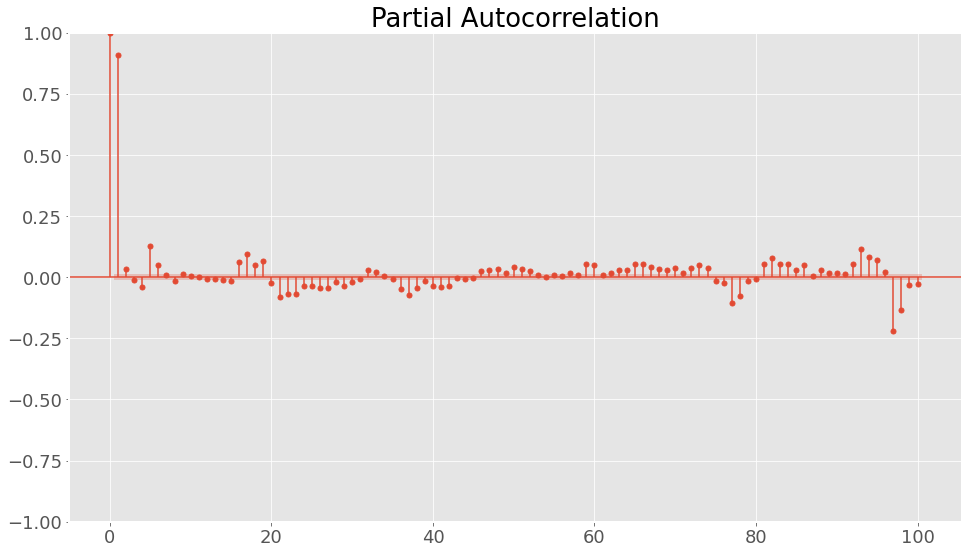

In [8]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure()
acf_values = acf(train)
plot_acf(train, lags=100)
plt.show()

plt.figure()
pacf_values = pacf(train)
plot_pacf(train, lags=100)
plt.show()

# Preprocess for SVM

In [9]:
# display(df)
# other_vars = ['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor',
#               'Leading_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM']
# other_vars_df = df[other_vars]
# # display(other_vars_df)
# other_vars_train = other_vars_df[:int(len(load)*0.7)]
# other_vars_test = other_vars_df[int(len(load)*0.7):]
# display(other_vars_train, other_vars_test)


In [10]:
df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)
for i in range(1,4):
    df_train["lag{}".format(i)] = df_train["Usage_kWh"].shift(i)
    df_test["lag{}".format(i)] = df_test["Usage_kWh"].shift(i)

# df_train = pd.merge(df_train, other_vars_train, left_index=True, right_index=True, how = 'outer')
# df_test = pd.merge(df_test, other_vars_test, left_index=True, right_index=True, how = 'outer')

df_train = df_train.fillna(0)
df_train = df_train.drop(columns = ["Usage_kWh"])
df_test = df_test.fillna(0)
df_test = df_test.drop(columns = ["Usage_kWh"])

display(df_train, df_test)

,lag1,lag2,lag3
0,0.00,0.00,0.00
1,3.17,0.00,0.00
2,4.00,3.17,0.00
3,3.24,4.00,3.17
4,3.31,3.24,4.00
...,...,...,...
24523,51.80,78.44,123.55
24524,53.60,51.80,78.44
24525,50.33,53.60,51.80
24526,51.01,50.33,53.60


,lag1,lag2,lag3
24528,0.00,0.00,0.00
24529,7.31,0.00,0.00
24530,4.43,7.31,0.00
24531,4.50,4.43,7.31
24532,5.08,4.50,4.43
...,...,...,...
35035,3.82,3.67,3.24
35036,3.85,3.82,3.67
35037,3.74,3.85,3.82
35038,3.78,3.74,3.85


# ARIMA - SVM

## ARIMA

In [11]:
from statsmodels.tsa.arima.model import ARIMA
 
# Build Model
arima = ARIMA(train, order=(1, 1, 1)).fit()
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:              Usage_kWh   No. Observations:                24528
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -100066.324
Date:                Thu, 14 Jul 2022   AIC                         200138.648
Time:                        05:20:23   BIC                         200162.971
Sample:                             0   HQIC                        200146.528
                              - 24528                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9072      0.002    454.408      0.000       0.903       0.911
ma.L1         -0.9995      0.000  -4000.960      0.000      -1.000      -0.999
sigma2       204.7163      0.868    235.972      0.0

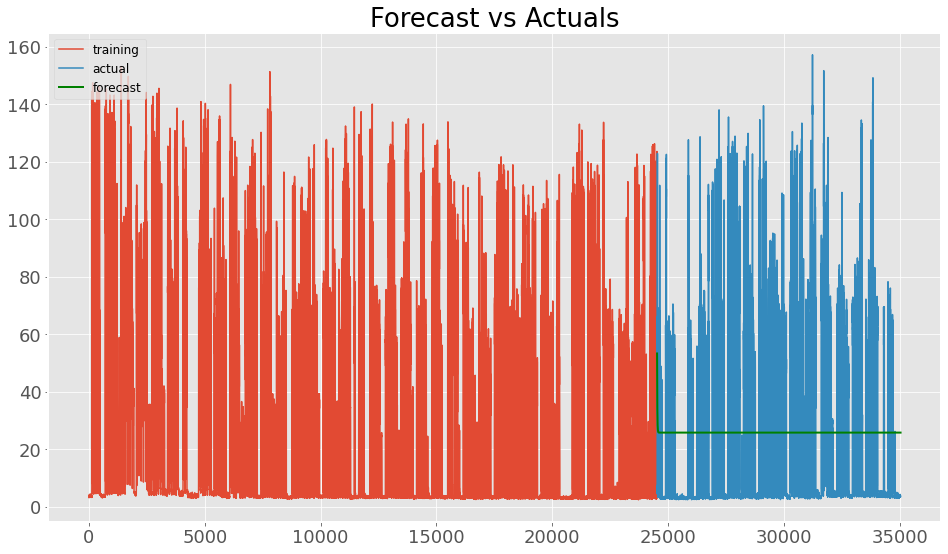

In [12]:
# plotting
arima_fc = arima.forecast(len(test)) 

# Make as pandas series
fc_series = pd.Series(arima_fc, index = [x for x in range(len(train),len(train)+len(test))])
test_series = pd.Series(test, index = [x for x in range(len(train),len(train)+len(test))])
# Plot
plt.plot(train, label='training')
plt.plot(test_series, label='actual')
plt.plot(fc_series, label='forecast', linewidth = 2, c = 'g')
# plt.plot(arima.predict(), label = 'fit')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)
plt.savefig('ARIMA.png')
plt.show()

In [13]:
RMSE_ARIMA = mean_squared_error(test, arima_fc)
MAE_ARIMA  =mean_absolute_error(test, arima_fc)
MAPE_ARIMA = mean_absolute_percentage_error(test, arima_fc)
print('RMSE = {}'.format(RMSE_ARIMA), '\nMAE = {}'.format(MAE_ARIMA), '\nMAPE = {}'.format(MAPE_ARIMA))

RMSE = 956.6311507341586 
MAE = 26.78752927409664 
MAPE = 4.261958564245863


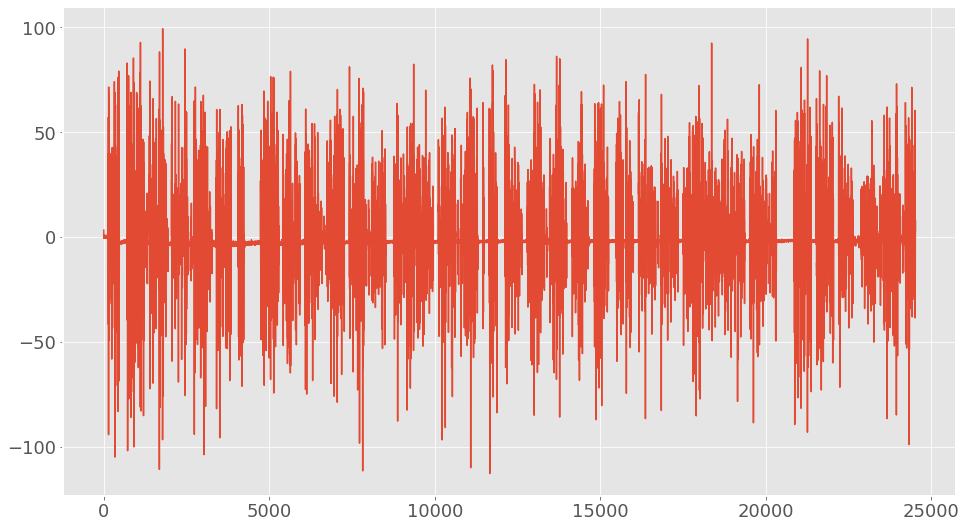

In [14]:
plt.plot(arima.resid)
plt.savefig('arimaresid')
plt.show()

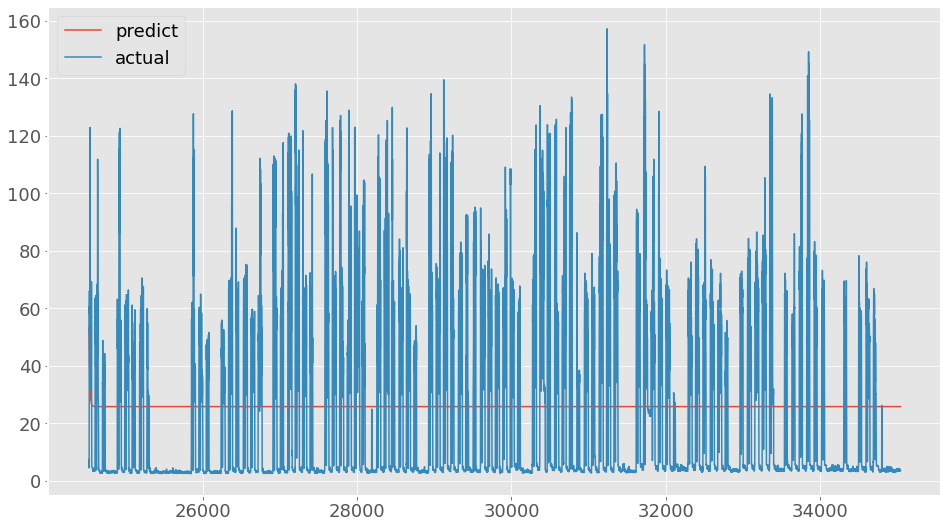

In [15]:
plt.plot(arima_fc, label = 'predict')
plt.plot(test, label = 'actual')
plt.legend()
plt.savefig('ARIMApredict')
plt.show()


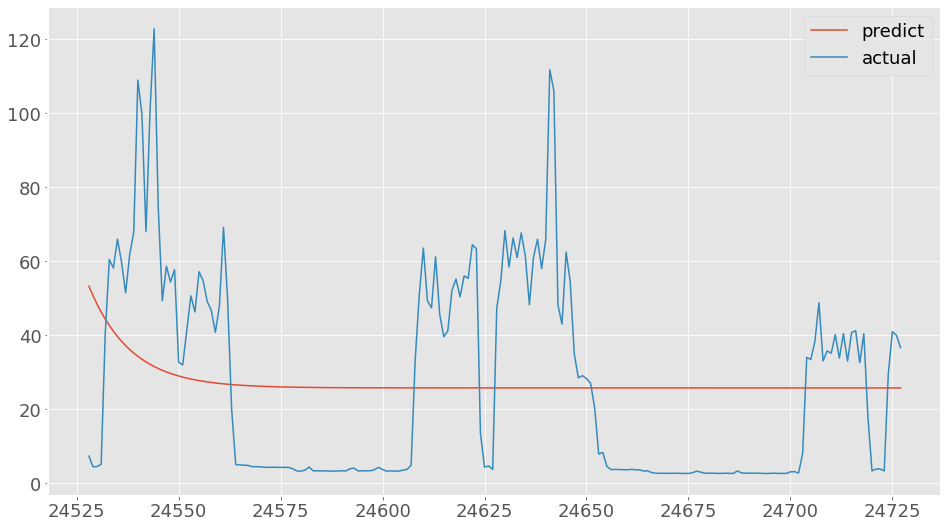

In [16]:
plt.plot(arima_fc[:200], label = 'predict')
plt.plot(test[:200], label = 'actual')
plt.legend()
plt.savefig('ARIMApredict_200')
plt.show()

In [17]:
arima_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
arima_SVR.fit(df_train.values, arima.resid)
arima_SVR_fc = arima_SVR.predict(np.array(df_test))

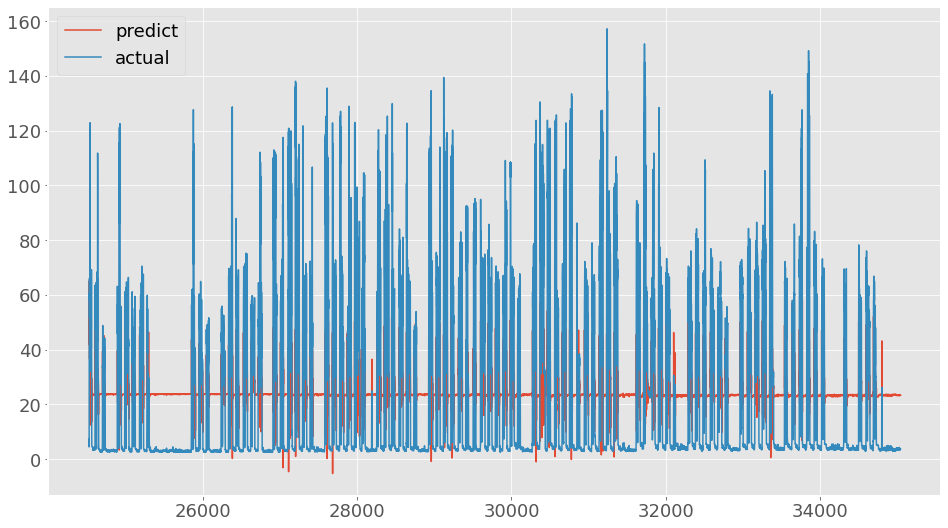

In [18]:
# print(arimia_SVR)
plt.plot(arima_SVR_fc+arima_fc, label = 'predict')
plt.plot(test, label = 'actual')
plt.legend()
plt.savefig('ARIMASVR')
plt.show()


In [19]:
RMSE_arima_svm = mean_squared_error(test, arima_SVR_fc+arima_fc)
MAE_arima_svm  =mean_absolute_error(test, arima_SVR_fc+arima_fc)
MAPE_arima_svm = mean_absolute_percentage_error(test, arima_SVR_fc+arima_fc)
print('RMSE = {}'.format(RMSE_arima_svm), '\nMAE = {}'.format(MAE_arima_svm), '\nMAPE = {}'.format(MAPE_arima_svm))

RMSE = 858.7260460795776 
MAE = 24.550919319923022 
MAPE = 3.8310196347492846


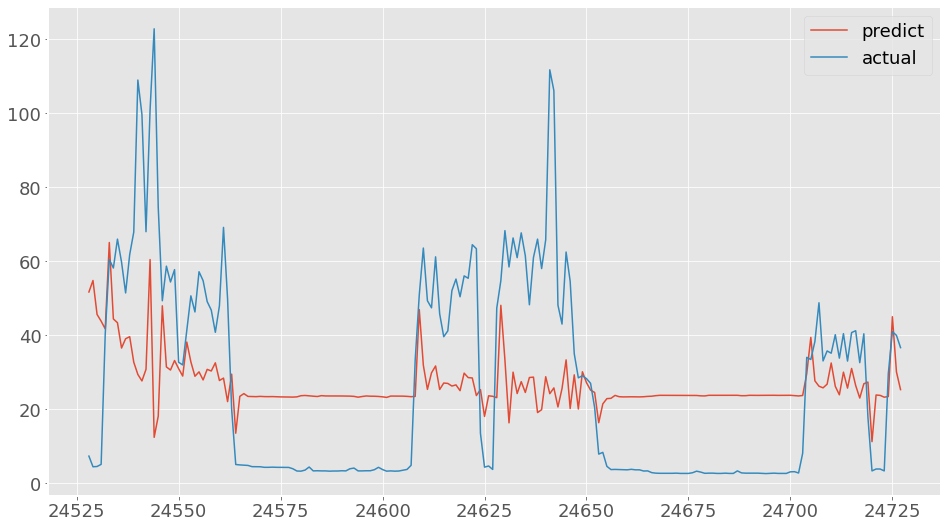

In [20]:
#test area
plt.plot(arima_SVR_fc[:200]+arima_fc[:200], label = 'predict')
plt.plot(test[:200], label = 'actual')
plt.legend()
plt.savefig('ARIMASVR_200')
plt.show()

# Holt-Winter - SVM

## Holt-Winter

In [21]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
holt_winter = HWES(train, seasonal_periods=12, trend = 'add', seasonal='add').fit()
print(holt_winter.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                Usage_kWh   No. Observations:                24528
Model:             ExponentialSmoothing   SSE                        5093166.374
Optimized:                         True   AIC                         130909.475
Trend:                         Additive   BIC                         131039.197
Seasonal:                      Additive   AICC                        130909.503
Seasonal Periods:                    12   Date:                 Thu, 14 Jul 2022
Box-Cox:                          False   Time:                         05:21:16
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9213360                alpha                 True
smoothing_trend          

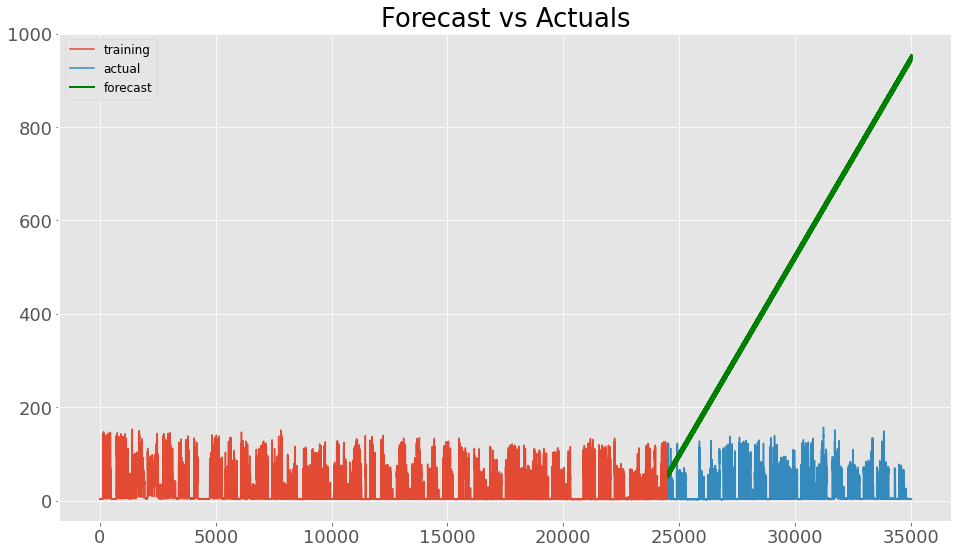

24528    50.105603
dtype: float64


In [22]:
hw_fc = holt_winter.forecast(len(test)) 

# Make as pandas series
hw_series = pd.Series(hw_fc, index = [x for x in range(len(train),len(train)+len(test))])
test_series = pd.Series(test, index = [x for x in range(len(train),len(train)+len(test))])
# Plot
plt.plot(train, label='training')
plt.plot(test_series, label='actual')
plt.plot(hw_series, label='forecast', linewidth = 2, c = 'g')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)
plt.savefig('HW')
plt.show()
print(holt_winter.predict(len(train)))

In [23]:
RMSE_HW = mean_squared_error(test, hw_fc)
MAE_HW  =mean_absolute_error(test, hw_fc)
MAPE_HW = mean_absolute_percentage_error(test, hw_fc)
print('RMSE = {}'.format(RMSE_HW), '\nMAE = {}'.format(MAE_HW), '\nMAPE = {}'.format(MAPE_HW))

RMSE = 295954.9448668192 
MAE = 478.4600461031028 
MAPE = 90.03397094761094


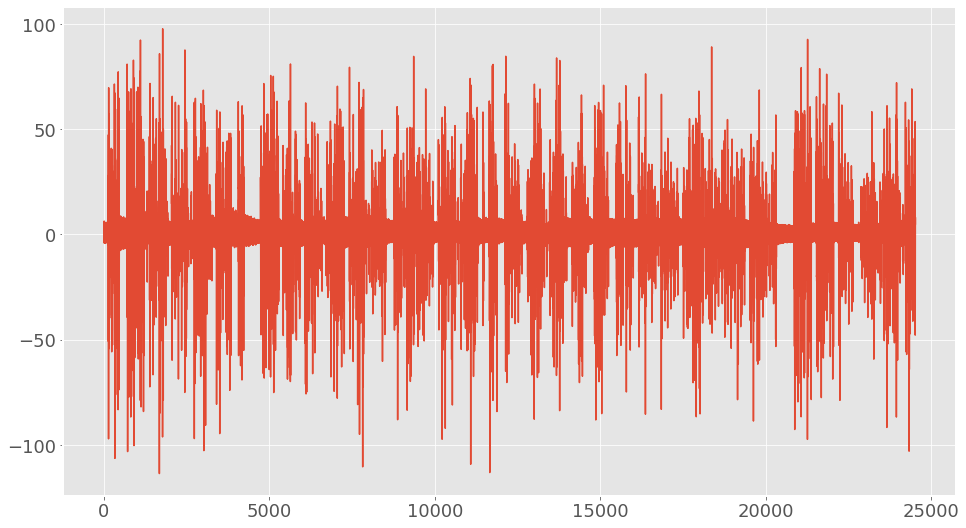

In [24]:
plt.plot(holt_winter.resid)
plt.savefig('hwresid')
plt.show()

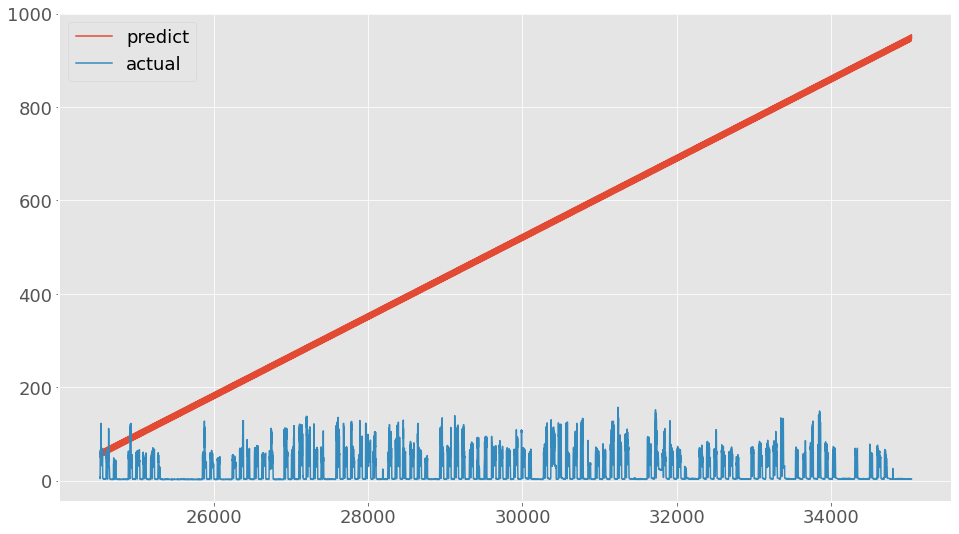

In [25]:
plt.plot(hw_fc, label = 'predict')
plt.plot(test, label = 'actual')
plt.legend()
plt.savefig('HWpredict')
plt.show()


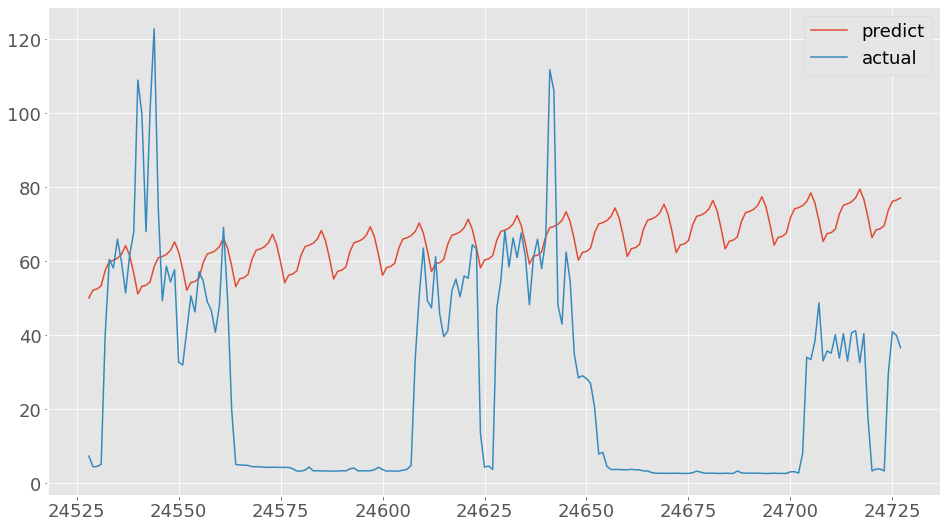

In [26]:
plt.plot(hw_fc[:200], label = 'predict')
plt.plot(test[:200], label = 'actual')
plt.legend()
plt.savefig('HWpredict_200')
plt.show()


In [27]:
hw_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
hw_SVR.fit(df_train.values, holt_winter.resid)

hw_SVR_fc = hw_SVR.predict(np.array(df_test))
# print(arimia_SVR)

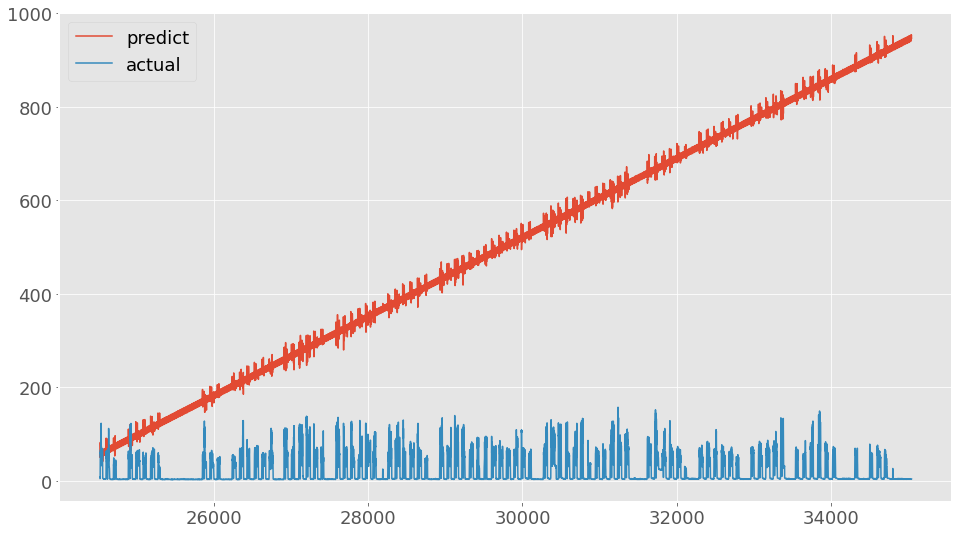

In [28]:
plt.plot(hw_SVR_fc+hw_fc, label = 'predict')
plt.plot(test, label = 'actual')
plt.legend()
plt.savefig('HWSVR')
plt.show()

In [29]:
RMSE_hw_SVR = mean_squared_error(test, hw_SVR_fc+hw_fc)
MAE_hw_SVR  =mean_absolute_error(test, hw_SVR_fc+hw_fc)
MAPE_hw_SVR = mean_absolute_percentage_error(test, hw_SVR_fc+hw_fc)
print('RMSE = {}'.format(RMSE_hw_SVR), '\nMAE = {}'.format(MAE_hw_SVR), '\nMAPE = {}'.format(MAPE_hw_SVR))

RMSE = 295750.31581625744 
MAE = 478.2576150837763 
MAPE = 90.00538951563705


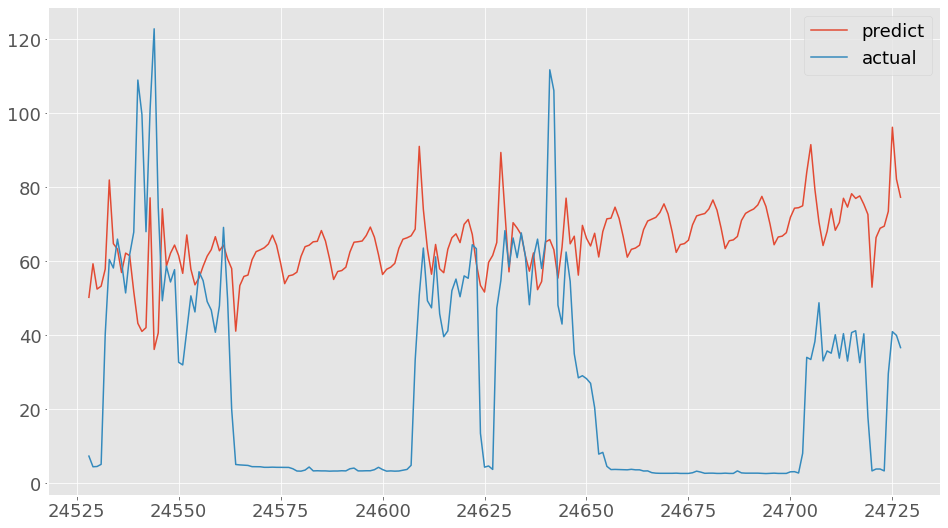

In [30]:
plt.plot(hw_SVR_fc[:200]+hw_fc[:200], label = 'predict')
plt.plot(test[:200], label = 'actual')
plt.legend()
plt.savefig('HWSVR_200')
plt.show()

# SVM

In [31]:
SVR_m = SVR(kernel = 'rbf', C= 0.5, gamma= 0.01).fit(df_train.values, train)

SVR_fc = SVR_m.predict(np.array(df_test))

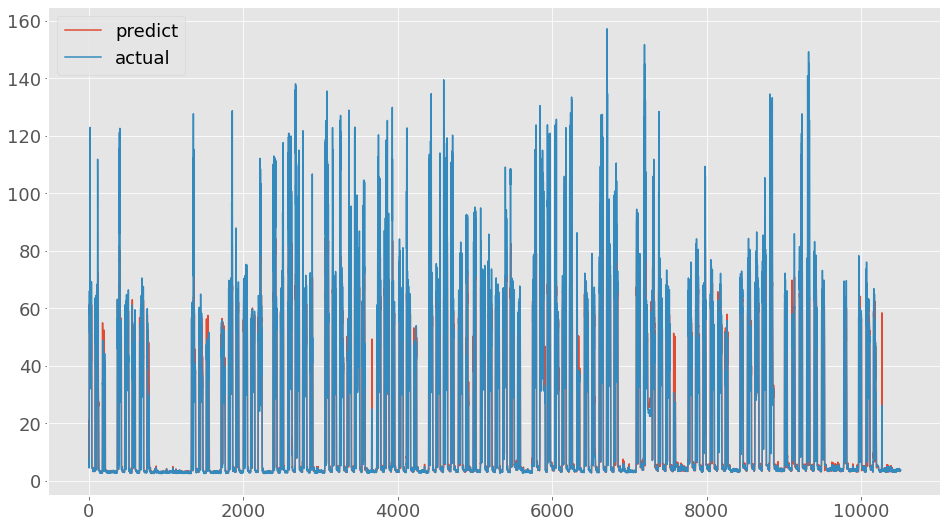

In [32]:
plt.plot(SVR_fc, label = 'predict')
plt.plot(test.values, label = 'actual')
plt.legend()
plt.savefig('SVR')
plt.show()

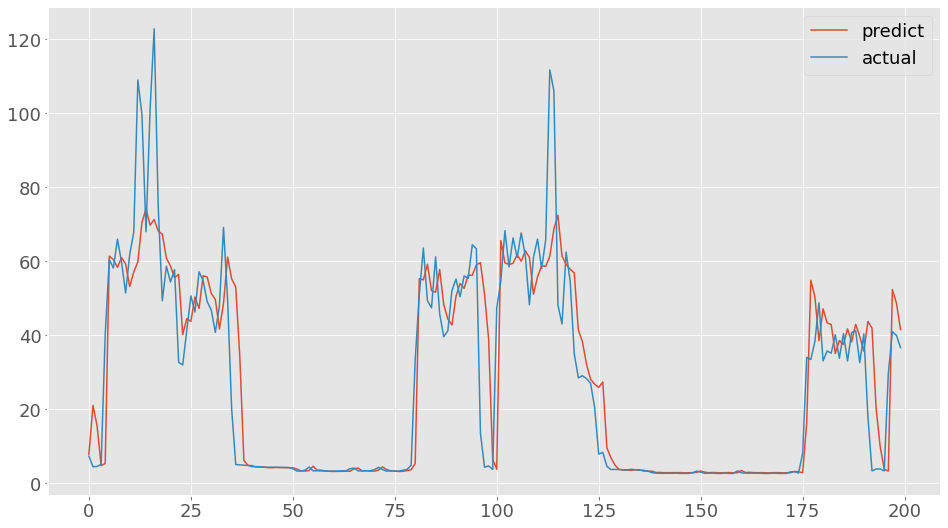

In [33]:
plt.plot(SVR_fc[:200], label = 'predict')
plt.plot(test.values[:200], label = 'actual')
plt.legend()
plt.savefig('SVR_200')
plt.show()


In [34]:
RMSE_SVR = mean_squared_error(test, SVR_fc)
MAE_SVR  =mean_absolute_error(test, SVR_fc)
MAPE_SVR = mean_absolute_percentage_error(test, SVR_fc)
print('RMSE = {}'.format(RMSE_SVR), '\nMAE = {}'.format(MAE_SVR), '\nMAPE = {}'.format(MAPE_SVR))

RMSE = 190.56766726507306 
MAE = 6.360496584145869 
MAPE = 0.3986853208902765


# Moving Average 3

In [35]:
MA_3_train = pd.DataFrame(train).rolling(window=3).mean().fillna(0)
MA_3_test = pd.DataFrame(test).rolling(window=3).mean().fillna(0)
# display(MA_3_train, MA_3_test)

In [36]:
SVR_MA_3 = SVR(kernel = 'rbf', C= 0.5, gamma= 0.01).fit(MA_3_train.values, train)
SVR_MA_3_fc = SVR_MA_3.predict(np.array(MA_3_test))

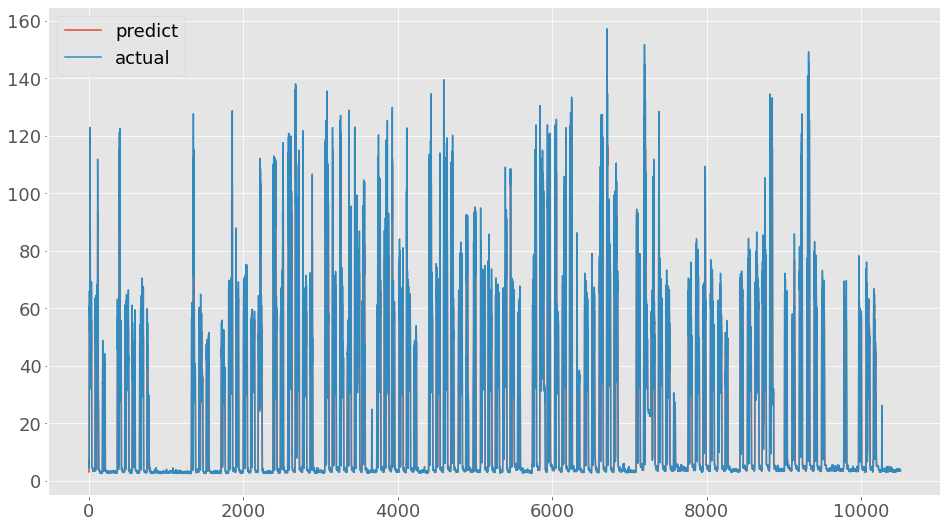

In [37]:
plt.plot(SVR_MA_3_fc, label = 'predict')
plt.plot(test.values, label = 'actual')
plt.legend()
plt.savefig('SVR_MA3')
plt.show()

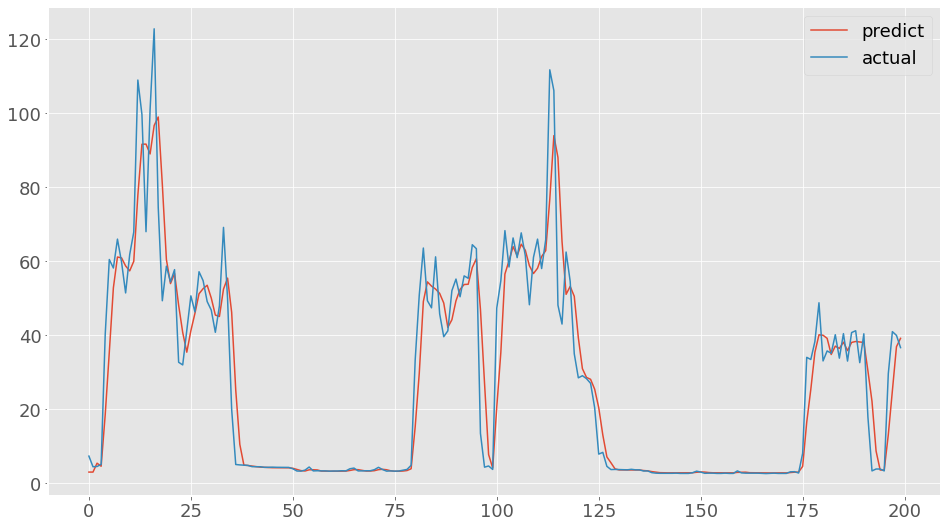

In [38]:
plt.plot(SVR_MA_3_fc[0:200], label = 'predict')
plt.plot(test.values[0:200], label = 'actual')
plt.legend()
plt.savefig('SVR_MA3_200')
plt.show()

In [39]:
RMSE_SVR_MA3 = mean_squared_error(test, SVR_MA_3_fc)
MAE_SVR_MA3  =mean_absolute_error(test, SVR_MA_3_fc)
MAPE_SVR_MA3 = mean_absolute_percentage_error(test, SVR_MA_3_fc)
print('RMSE = {}'.format(RMSE_SVR_MA3), '\nMAE = {}'.format(MAE_SVR_MA3), '\nMAPE = {}'.format(MAPE_SVR_MA3))

RMSE = 85.0789109852234 
MAE = 4.158382367642411 
MAPE = 0.21261519859396982


# Empirical M Decomposition - SVM

In [40]:
!pip install emd
# !pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 6.9 MB/s eta 0:00:00


 The argument 'scale_y' is depreciated and will be                         removed in a future version. Please use 'sharey' to remove this                         warning


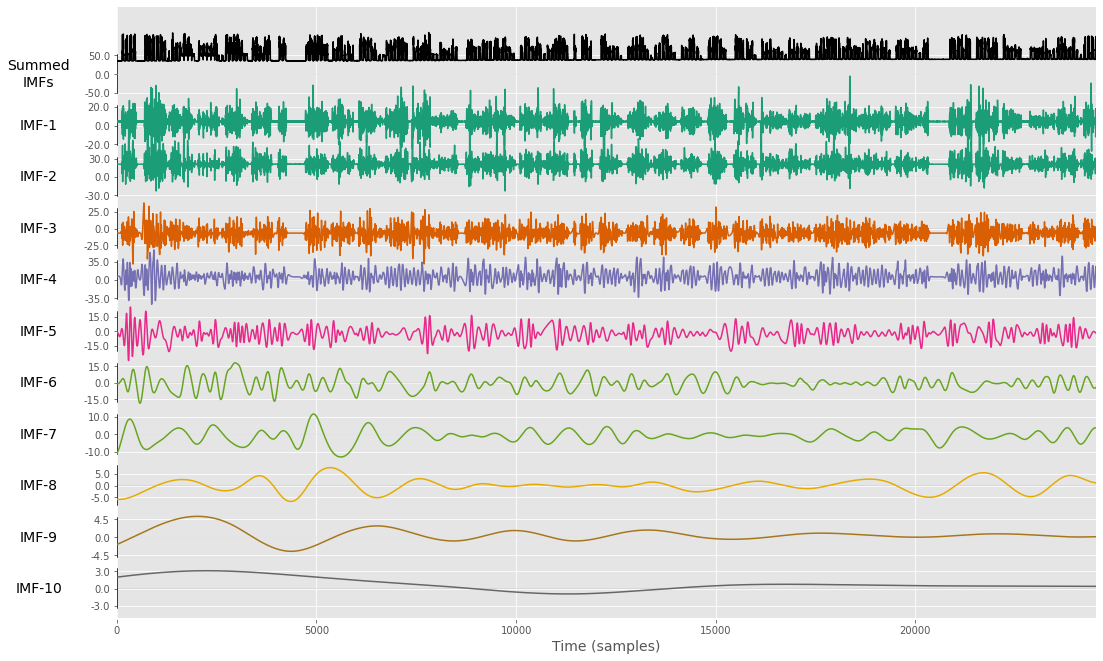

In [41]:
import emd

imf = emd.sift.sift(np.array(train), imf_opts={'sd_thresh': 0.1})
emd.plotting.plot_imfs(imf, cmap=True, scale_y=True)
plt.savefig('emd')
plt.show()

In [42]:
#put the imf into dataframe
imf_df = pd.DataFrame(data = imf)
imf_df.columns = ['imf_{}'.format(i+1) for i in range(0, imf.shape[1])]
display(imf_df)

,imf_1,imf_2,imf_3,imf_4,imf_5,imf_6,imf_7,imf_8,imf_9,imf_10
0,-0.410418,0.096734,0.012662,0.266056,4.654688,0.067477,-20.472990,-11.796666,-4.588843,3.082662
1,0.400239,0.121368,-0.002632,0.334189,4.568617,0.017735,-20.403255,-11.799372,-4.579866,3.084406
2,-0.368732,0.130672,-0.013657,0.404290,4.477960,-0.030306,-20.331976,-11.802020,-4.570887,3.086150
3,-0.285557,0.112370,-0.019505,0.475967,4.382699,-0.076631,-20.259160,-11.804611,-4.561904,3.087894
4,0.264102,0.062765,-0.020476,0.548891,4.282814,-0.121229,-20.184814,-11.807144,-4.552917,3.089637
...,...,...,...,...,...,...,...,...,...,...
24523,2.139145,-10.275599,-4.272019,39.139285,1.708957,-7.500440,9.255424,2.328822,-0.622215,-0.109875
24524,2.974048,-9.148159,-9.567093,39.219571,1.639081,-7.438328,9.247855,2.325870,-0.621509,-0.109998
24525,-0.504868,-0.677014,-13.606295,38.962034,1.570491,-7.374875,9.239659,2.322986,-0.620802,-0.110122
24526,-0.003040,6.863818,-15.593641,38.360157,1.503190,-7.310106,9.230840,2.320169,-0.620094,-0.110245


In [43]:
imf1_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf1_SVR.fit(df_train.values, imf_df['imf_1'])
imf1_SVR_fc = imf1_SVR.predict(np.array(df_test))

imf2_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf2_SVR.fit(df_train.values, imf_df['imf_2'])
imf2_SVR_fc = imf2_SVR.predict(np.array(df_test))

imf3_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf3_SVR.fit(df_train.values, imf_df['imf_3'])
imf3_SVR_fc = imf3_SVR.predict(np.array(df_test))

imf4_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf4_SVR.fit(df_train.values, imf_df['imf_4'])
imf4_SVR_fc = imf4_SVR.predict(np.array(df_test))

imf5_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf5_SVR.fit(df_train.values, imf_df['imf_5'])
imf5_SVR_fc = imf5_SVR.predict(np.array(df_test))

imf6_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf6_SVR.fit(df_train.values, imf_df['imf_6'])
imf6_SVR_fc = imf6_SVR.predict(np.array(df_test))

imf7_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf7_SVR.fit(df_train.values, imf_df['imf_7'])
imf7_SVR_fc = imf7_SVR.predict(np.array(df_test))

imf8_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf8_SVR.fit(df_train.values, imf_df['imf_8'])
imf8_SVR_fc = imf8_SVR.predict(np.array(df_test))

imf9_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf9_SVR.fit(df_train.values, imf_df['imf_9'])
imf9_SVR_fc = imf9_SVR.predict(np.array(df_test))

imf10_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf10_SVR.fit(df_train.values, imf_df['imf_10'])
imf10_SVR_fc = imf10_SVR.predict(np.array(df_test))

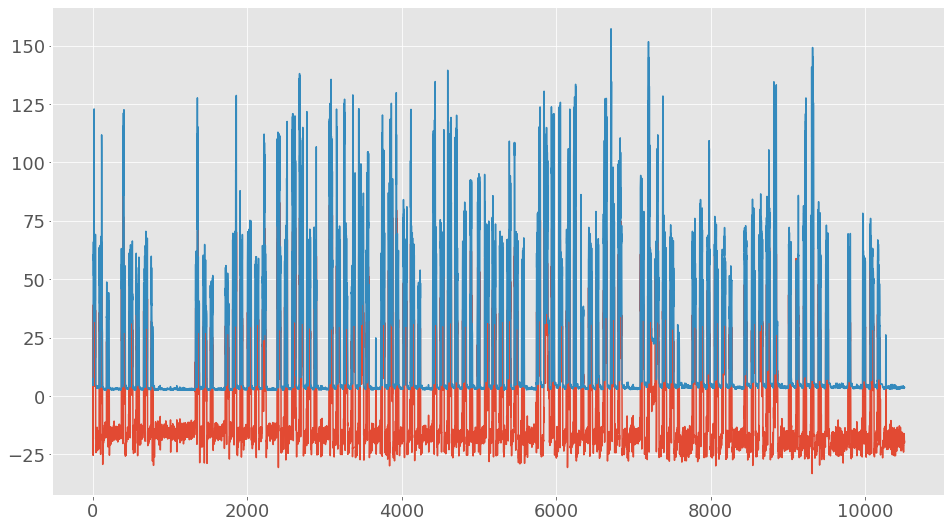

In [44]:
imf_list = ['imf{}_SVR_fc'.format(i) for i in range(1,11)]

imf_fc = np.sum([imf1_SVR_fc, imf2_SVR_fc, imf3_SVR_fc,
                imf4_SVR_fc, imf5_SVR_fc,imf6_SVR_fc,
                imf7_SVR_fc,imf8_SVR_fc,imf9_SVR_fc, imf10_SVR_fc], axis = 0)

plt.plot(imf_fc)
plt.plot(test.values)

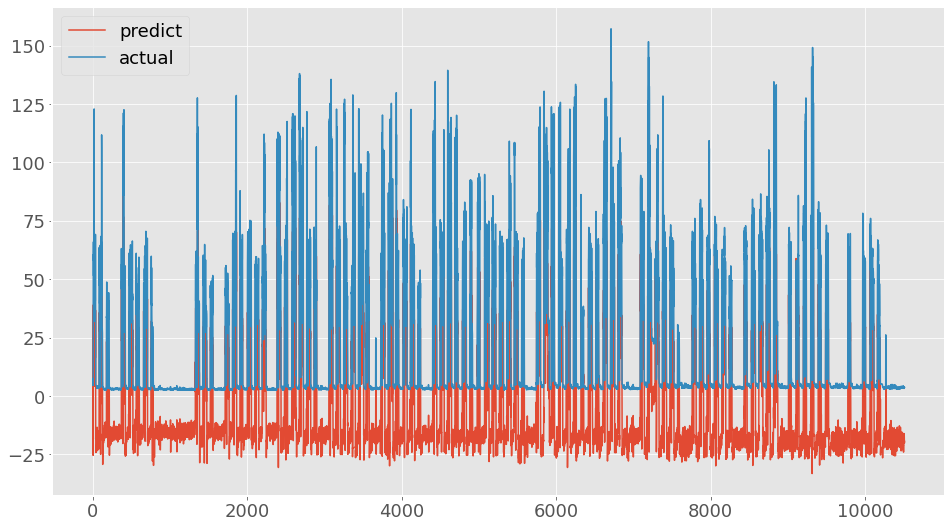

RMSE = 760.1433581743336 
MAE = 25.098743243154697 
MAPE = 4.04511046836792


In [45]:
plt.plot(imf_fc,label = 'predict')
plt.plot(test.values, label = 'actual')
plt.legend()
plt.savefig('EMDSVR')
plt.show()

RMSE_EMD_SVR = mean_squared_error(test, imf_fc)
MAE_EMD_SVR  =mean_absolute_error(test, imf_fc)
MAPE_EMD_SVR = mean_absolute_percentage_error(test, imf_fc)
print('RMSE = {}'.format(RMSE_EMD_SVR), '\nMAE = {}'.format(MAE_EMD_SVR), '\nMAPE = {}'.format(MAPE_EMD_SVR))

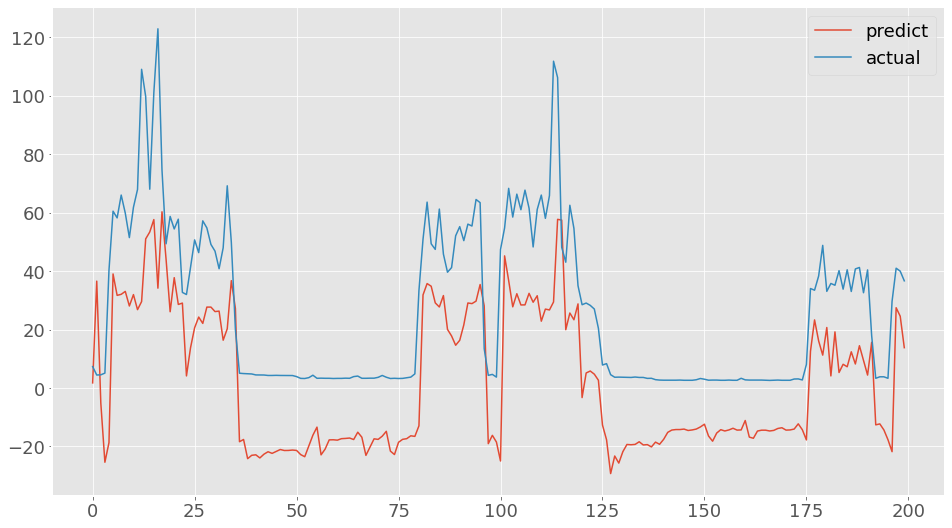

In [46]:
plt.plot(imf_fc[:200], label = 'predict')
plt.plot(test[:200].values, label = 'actual')
plt.legend()
plt.savefig('EMDSVR_200')
plt.show()

In [47]:
imf1_SVR_fc = imf1_SVR.predict(np.array(df_train))
imf2_SVR_fc = imf2_SVR.predict(np.array(df_train))
imf3_SVR_fc = imf3_SVR.predict(np.array(df_train))
imf4_SVR_fc = imf4_SVR.predict(np.array(df_train))
imf5_SVR_fc = imf5_SVR.predict(np.array(df_train))
imf6_SVR_fc = imf6_SVR.predict(np.array(df_train))
imf7_SVR_fc = imf7_SVR.predict(np.array(df_train))
imf8_SVR_fc = imf8_SVR.predict(np.array(df_train))
imf9_SVR_fc = imf9_SVR.predict(np.array(df_train))
imf10_SVR_fc = imf10_SVR.predict(np.array(df_train))

imf_fc_train = np.sum([imf1_SVR_fc, imf2_SVR_fc, imf3_SVR_fc,
                imf4_SVR_fc, imf5_SVR_fc,imf6_SVR_fc,
                imf7_SVR_fc,imf8_SVR_fc,imf9_SVR_fc, imf10_SVR_fc], axis = 0)

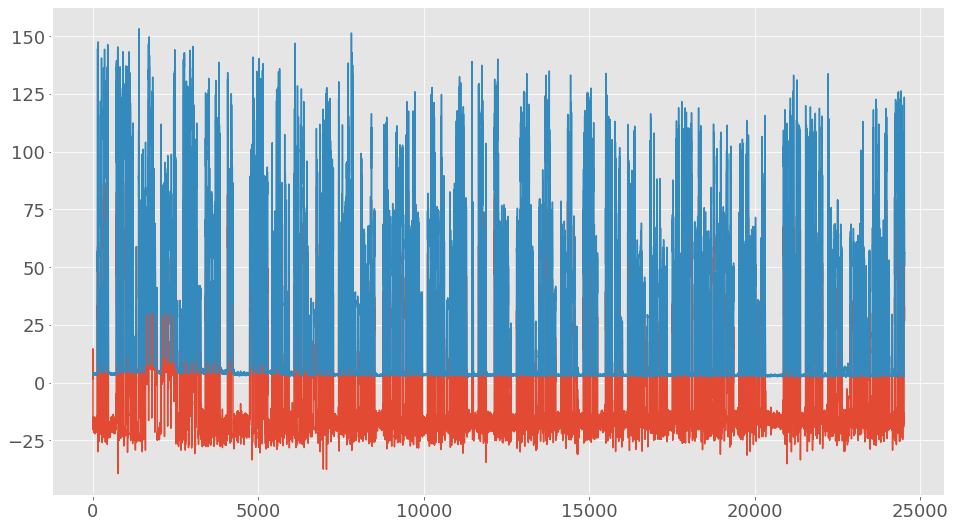

In [48]:
plt.plot(imf_fc_train)
plt.plot(train.values)

In [49]:
RMSE_EMD_SVR = mean_squared_error(train, imf_fc_train, squared = False)
MAE_EMD_SVR  =mean_absolute_error(train, imf_fc_train)
MAPE_EMD_SVR = mean_absolute_percentage_error(train, imf_fc_train)
print('RMSE = {}'.format(RMSE_EMD_SVR), '\nMAE = {}'.format(MAE_EMD_SVR), '\nMAPE = {}'.format(MAPE_EMD_SVR))

RMSE = 28.92897589097748 
MAE = 26.053067225665774 
MAPE = 3.717202912768114


In [50]:
import numpy as np
from scipy.optimize import minimize

def dummy(c):
    global  train
    global imf_fc_train
    return mean_squared_error(train, imf_fc_train + c, squared = False)

res = minimize(dummy, 0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})
print(res.x)

Optimization terminated successfully.
         Current function value: 13.776084
         Iterations: 47
         Function evaluations: 97
[25.43826184]


In [51]:
# plt.plot(imf_fc_train + res.x)
# plt.plot(train.values)
# RMSE_EMD_SVR = mean_squared_error(train, imf_fc_train + res.x)
# MAE_EMD_SVR  =mean_absolute_error(train, imf_fc_train + res.x)
# MAPE_EMD_SVR = mean_absolute_percentage_error(train, imf_fc_train + res.x)
# print('RMSE = {}'.format(RMSE_EMD_SVR), '\nMAE = {}'.format(MAE_EMD_SVR), '\nMAPE = {}'.format(MAPE_EMD_SVR))

In [52]:
RMSE_EMD_SVR = mean_squared_error(test, imf_fc + res.x[0])
MAE_EMD_SVR  =mean_absolute_error(test, imf_fc + res.x[0])
MAPE_EMD_SVR = mean_absolute_percentage_error(test, imf_fc + res.x[0])
print('RMSE = {}'.format(RMSE_EMD_SVR), '\nMAE = {}'.format(MAE_EMD_SVR), '\nMAPE = {}'.format(MAPE_EMD_SVR))

RMSE = 161.21192285884575 
MAE = 8.08242312674676 
MAPE = 1.0589349003571427


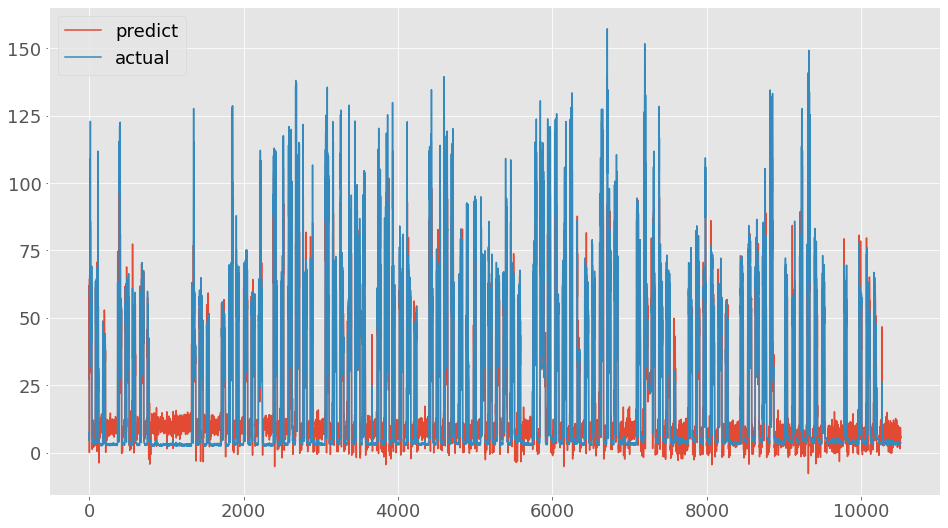

In [53]:
plt.plot(imf_fc + res.x[0], label = 'predict')
plt.plot(test.values, label = 'actual')
plt.legend()
plt.savefig('ImprovedEMDSVR')
plt.show()

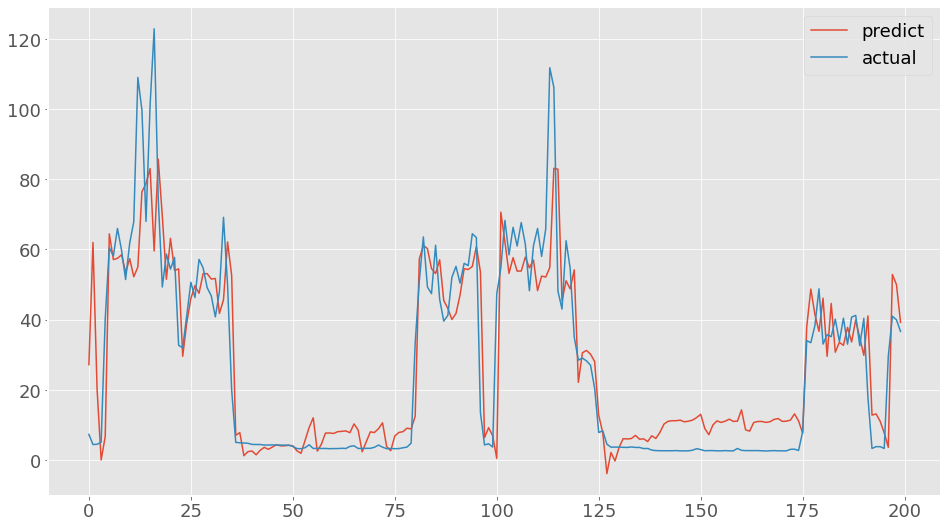

RMSE = 161.21192285884575 
MAE = 8.08242312674676 
MAPE = 1.0589349003571427


In [54]:
plt.plot(imf_fc[:200] + res.x[0], label = 'predict')
plt.plot(test.values[:200], label = 'actual')
plt.legend()
plt.savefig('ImprovedEMDSVR_200')
plt.show()
print('RMSE = {}'.format(RMSE_EMD_SVR), '\nMAE = {}'.format(MAE_EMD_SVR), '\nMAPE = {}'.format(MAPE_EMD_SVR))

In [55]:
# imf_add = emd.sift.sift(np.array(train) + res.x, imf_opts={'sd_thresh': 0.1})
# emd.plotting.plot_imfs(imf, cmap=True, scale_y=True)
# # plt.savefig('emd')
# plt.show()

In [56]:
# imf_df_add = pd.DataFrame(data = imf_add)
# imf_df_add.columns = ['imf_{}'.format(i+1) for i in range(0, imf.shape[1])]
# display(imf_df_add)

In [57]:
# imf1_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf1_SVR.fit(df_train.values, imf_df_add['imf_1'])
# imf1_SVR_fc = imf1_SVR.predict(np.array(df_test))

# imf2_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf2_SVR.fit(df_train.values, imf_df_add['imf_2']) 
# imf2_SVR_fc = imf2_SVR.predict(np.array(df_test))

# imf3_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf3_SVR.fit(df_train.values, imf_df_add['imf_3'])
# imf3_SVR_fc = imf3_SVR.predict(np.array(df_test))

# imf4_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf4_SVR.fit(df_train.values, imf_df_add['imf_4'])
# imf4_SVR_fc = imf4_SVR.predict(np.array(df_test))

# imf5_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf5_SVR.fit(df_train.values, imf_df_add['imf_5'])
# imf5_SVR_fc = imf5_SVR.predict(np.array(df_test))

# imf6_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf6_SVR.fit(df_train.values, imf_df_add['imf_6'])
# imf6_SVR_fc = imf6_SVR.predict(np.array(df_test))

# imf7_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf7_SVR.fit(df_train.values, imf_df_add['imf_7'])
# imf7_SVR_fc = imf7_SVR.predict(np.array(df_test))

# imf8_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf8_SVR.fit(df_train.values, imf_df_add['imf_8'])
# imf8_SVR_fc = imf8_SVR.predict(np.array(df_test))

# imf9_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf9_SVR.fit(df_train.values, imf_df_add['imf_9'])
# imf9_SVR_fc = imf9_SVR.predict(np.array(df_test))

# imf10_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf10_SVR.fit(df_train.values, imf_df_add['imf_10'])
# imf10_SVR_fc = imf10_SVR.predict(np.array(df_test))

In [58]:
# imf_fc = np.sum([imf1_SVR_fc, imf2_SVR_fc, imf3_SVR_fc,
#                 imf4_SVR_fc, imf5_SVR_fc,imf6_SVR_fc,
#                 imf7_SVR_fc,imf8_SVR_fc,imf9_SVR_fc, imf10_SVR_fc], axis = 0)

# plt.plot(imf_fc)
# plt.plot(test.values)

# EEMD

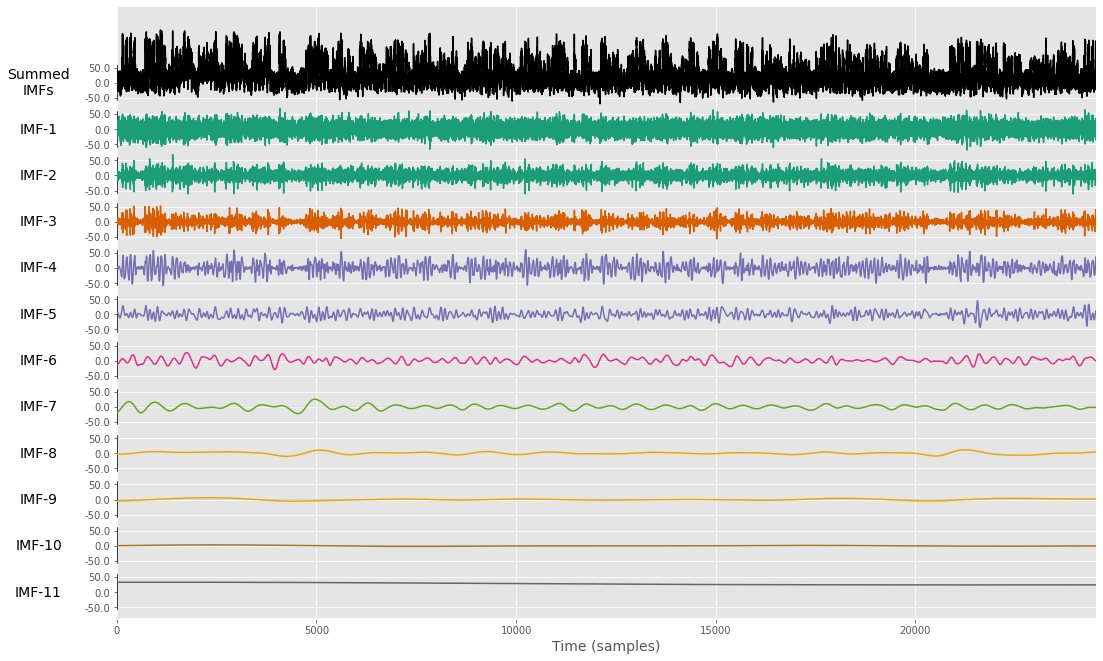

In [59]:
imf_eemd = emd.sift.ensemble_sift(np.array(train), nensembles=4, nprocesses=6, ensemble_noise=1, imf_opts={'sd_thresh': 0.1})
emd.plotting.plot_imfs(imf_eemd)
plt.savefig('eemd')

In [60]:
imf_eemd_df = pd.DataFrame(data = imf_eemd)
imf_eemd_df.columns = ['imf_eemd_{}'.format(i+1) for i in range(0, imf_eemd.shape[1])]
display(imf_eemd_df)


,imf_eemd_1,imf_eemd_2,imf_eemd_3,imf_eemd_4,imf_eemd_5,imf_eemd_6,imf_eemd_7,imf_eemd_8,imf_eemd_9,imf_eemd_10,imf_eemd_11
0,23.329957,-5.067154,-0.800813,1.436308,4.337236,-12.469803,-18.199790,-3.112186,-4.171935,0.647930,32.728969
1,4.809727,4.591239,-1.603021,2.343939,4.381251,-12.506945,-18.145141,-3.113115,-4.171004,0.649550,32.729168
2,28.423488,7.908331,-0.616288,3.306032,4.424496,-12.538696,-18.088727,-3.113993,-4.170062,0.651169,32.729368
3,-25.497503,-0.084194,1.455910,4.224735,4.466955,-12.565011,-18.030556,-3.114821,-4.169108,0.652788,32.729567
4,8.928118,-8.719260,3.570920,5.007692,4.508616,-12.585845,-17.970637,-3.115599,-4.168143,0.654406,32.729766
...,...,...,...,...,...,...,...,...,...,...,...
24523,-7.535101,-13.770236,-11.257105,37.150079,11.565718,-0.429725,-1.689881,4.207825,1.700358,-0.448601,24.163236
24524,-7.044301,-16.495425,-19.179384,36.691390,11.831038,-0.489213,-1.681456,4.206477,1.699890,-0.448373,24.163355
24525,21.605583,-5.586735,-24.089325,35.781669,12.018762,-0.545884,-1.672683,4.205045,1.699420,-0.448145,24.163474
24526,0.726292,5.975760,-25.469730,34.427358,12.126904,-0.599686,-1.663559,4.203527,1.698948,-0.447918,24.163594


In [61]:
imf1_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf1_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_1'])
imf1_eemd_SVR_fc = imf1_eemd_SVR.predict(np.array(df_test))

imf2_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf2_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_2'])
imf2_eemd_SVR_fc = imf2_eemd_SVR.predict(np.array(df_test))

imf3_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf3_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_3'])
imf3_eemd_SVR_fc = imf3_eemd_SVR.predict(np.array(df_test))

imf4_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf4_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_4'])
imf4_eemd_SVR_fc = imf4_eemd_SVR.predict(np.array(df_test))

imf5_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf5_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_5'])
imf5_eemd_SVR_fc = imf5_eemd_SVR.predict(np.array(df_test))

imf6_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf6_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_6'])
imf6_eemd_SVR_fc = imf6_eemd_SVR.predict(np.array(df_test))

imf7_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf7_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_7'])
imf7_eemd_SVR_fc = imf7_eemd_SVR.predict(np.array(df_test))

imf8_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf8_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_8'])
imf8_eemd_SVR_fc = imf8_eemd_SVR.predict(np.array(df_test))

imf9_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf9_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_9'])
imf9_eemd_SVR_fc = imf9_eemd_SVR.predict(np.array(df_test))

imf10_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf10_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_10'])
imf10_eemd_SVR_fc = imf10_eemd_SVR.predict(np.array(df_test))

imf11_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf11_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_11'])
imf11_eemd_SVR_fc = imf11_eemd_SVR.predict(np.array(df_test))


In [62]:
imf_eemd_list = ['imf{}_eemd_SVR_fc'.format(i) for i in range(1,11)]

imf_eemd_fc = np.sum([imf1_eemd_SVR_fc, imf2_eemd_SVR_fc, imf3_eemd_SVR_fc,
                imf4_eemd_SVR_fc, imf5_eemd_SVR_fc,imf6_eemd_SVR_fc,
                imf7_eemd_SVR_fc,imf8_eemd_SVR_fc,imf9_eemd_SVR_fc, imf10_eemd_SVR_fc,
                    imf11_eemd_SVR_fc], axis = 0)

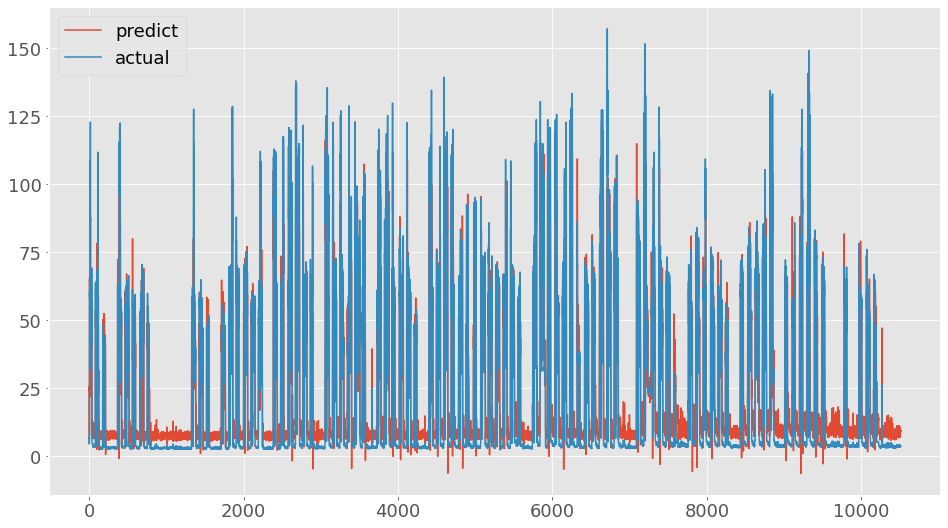

RMSE = 145.57680920175753 
MAE = 8.086083414529618 
MAPE = 1.082205651775251


In [63]:
plt.plot(imf_eemd_fc,label = 'predict')
plt.plot(test.values, label = 'actual')
plt.legend()
plt.savefig('EEMDSVR')
plt.show()

RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc)
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc)
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc)
print('RMSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

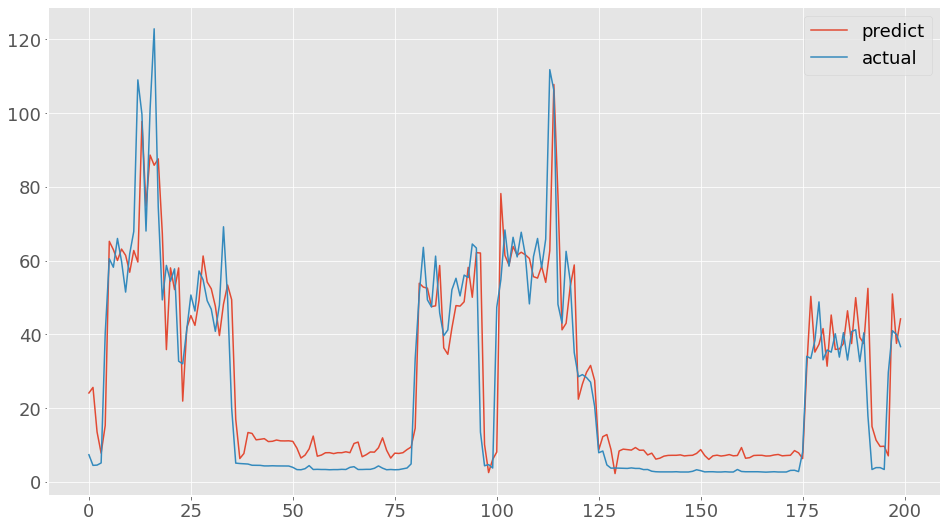

MSE = 145.57680920175753 
MAE = 8.086083414529618 
MAPE = 1.082205651775251


In [64]:
plt.plot(imf_eemd_fc[:200], label = 'predict')
plt.plot(test[:200].values, label = 'actual')
plt.legend()
plt.savefig('EEMDSVR_200')
plt.show()

RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc)
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc)
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc)
print('MSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

In [65]:
imf1_eemd_SVR_fc = imf1_eemd_SVR.predict(np.array(df_train))
imf2_eemd_SVR_fc = imf2_eemd_SVR.predict(np.array(df_train))
imf3_eemd_SVR_fc = imf3_eemd_SVR.predict(np.array(df_train))
imf4_eemd_SVR_fc = imf4_eemd_SVR.predict(np.array(df_train))
imf5_eemd_SVR_fc = imf5_eemd_SVR.predict(np.array(df_train))
imf6_eemd_SVR_fc = imf6_eemd_SVR.predict(np.array(df_train))
imf7_eemd_SVR_fc = imf7_eemd_SVR.predict(np.array(df_train))
imf8_eemd_SVR_fc = imf8_eemd_SVR.predict(np.array(df_train))
imf9_eemd_SVR_fc = imf9_eemd_SVR.predict(np.array(df_train))
imf10_eemd_SVR_fc = imf10_eemd_SVR.predict(np.array(df_train))
imf11_eemd_SVR_fc = imf11_eemd_SVR.predict(np.array(df_train))

imf_eemd_fc_train = np.sum([imf1_eemd_SVR_fc, imf2_eemd_SVR_fc, imf3_eemd_SVR_fc,
                imf4_eemd_SVR_fc, imf5_eemd_SVR_fc,imf6_eemd_SVR_fc,
                imf7_eemd_SVR_fc,imf8_eemd_SVR_fc,imf9_eemd_SVR_fc, imf10_eemd_SVR_fc,
                           imf11_eemd_SVR_fc], axis = 0)

In [66]:
def dummy1(c):
    global train
    global imf_eemd_fc_train
    return mean_squared_error(train, imf_eemd_fc_train + c)

res1 = minimize(dummy1, 0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})
print(res1.x)

Optimization terminated successfully.
         Current function value: 167.521801
         Iterations: 40
         Function evaluations: 85
[-2.24961768]


In [67]:
RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc + res1.x[0])
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc + res1.x[0])
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc + res1.x[0])
print('RMSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

RMSE = 137.64211935841755 
MAE = 6.861022288250934 
MAPE = 0.6856198232736564


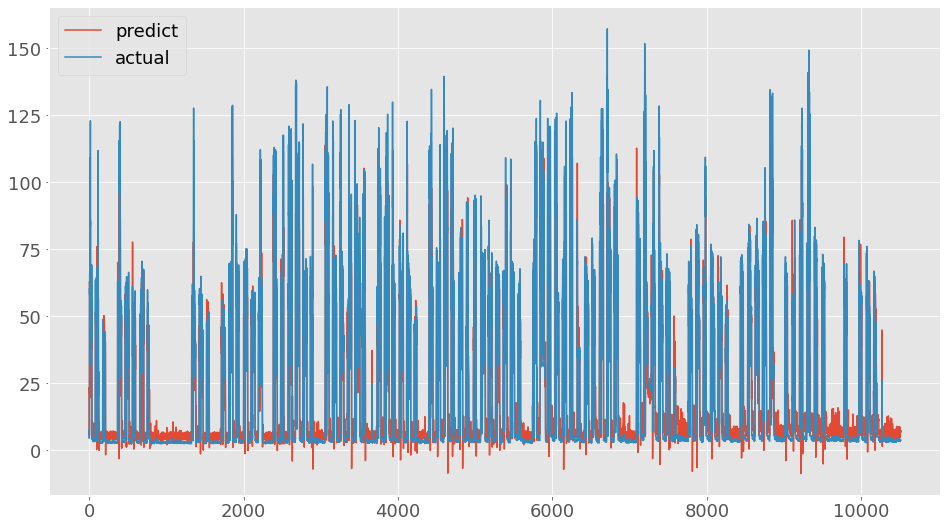

In [68]:
plt.plot(imf_eemd_fc + res1.x[0], label = 'predict')
plt.plot(test.values, label = 'actual')
plt.legend()
plt.savefig('ImprovedEEMDSVR')
plt.show()

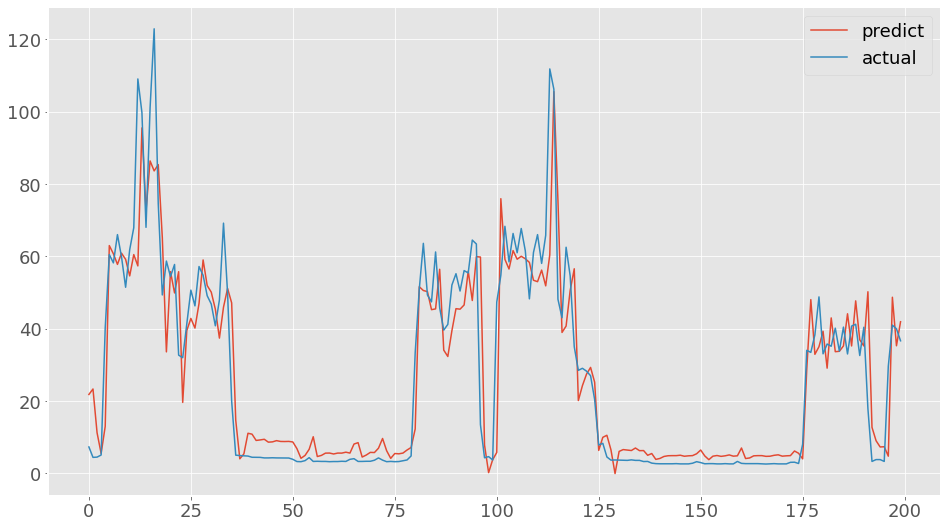

In [69]:
plt.plot(imf_eemd_fc[:200] + res1.x[0], label = 'predict')
plt.plot(test.values[:200], label = 'actual')
plt.legend()
plt.savefig('ImprovedEEMDSVR_200')
plt.show()

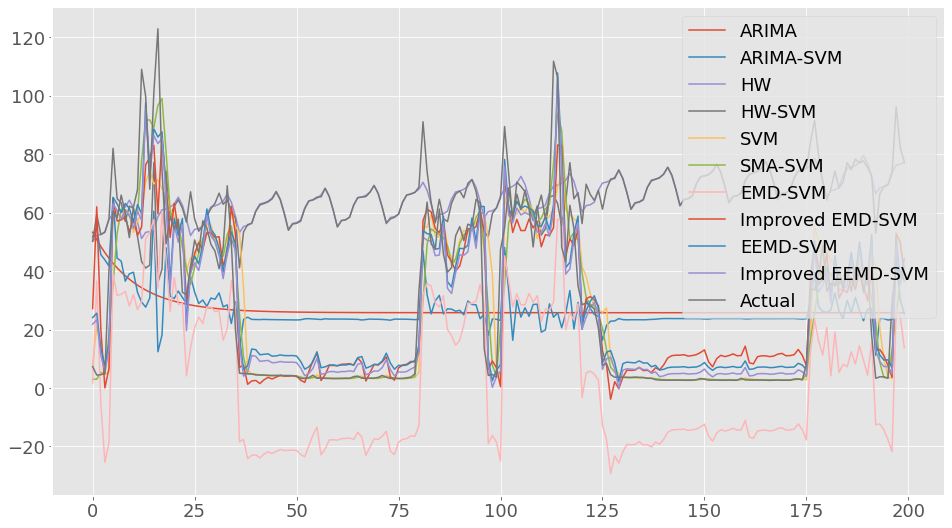

In [70]:
plt.plot(arima_fc.values[:200], label = 'ARIMA')
plt.plot(arima_SVR_fc[:200]+arima_fc.values[:200], label = 'ARIMA-SVM')
plt.plot(hw_fc.values[:200], label = 'HW')
plt.plot(hw_SVR_fc[:200]+hw_fc.values[:200], label = 'HW-SVM')
plt.plot(SVR_fc[:200], label = 'SVM')
plt.plot(SVR_MA_3_fc[0:200], label = 'SMA-SVM')
plt.plot(imf_fc[:200], label = 'EMD-SVM')
plt.plot(imf_fc[:200] + res.x[0], label = 'Improved EMD-SVM')
plt.plot(imf_eemd_fc[:200], label = 'EEMD-SVM')
plt.plot(imf_eemd_fc[:200] + res1.x[0], label = 'Improved EEMD-SVM')
plt.plot(test.values[:200], label = 'Actual')
plt.legend()
plt.savefig('Summary')
plt.show()

# The start of something new


In [71]:
# !pip install EMD-signal

# from PyEMD import EMD, EEMD

# eemd = EEMD()
# imfs = eemd(np.array(train))
# display(imfs)
# print(len(imfs))

# display(imfs)
# print(len(imfs))

# BACKLOG

In [72]:
# param_grid = [
#     {'C': [0.5, 1, 10],
#     'gamma': [1, 0.1, 0.01],
#     'kernel': ['rbf']},
# ]

# optimal_params = GridSearchCV(
#     SVR(),
#     param_grid,
#     cv = 5,
#     scoring = 'neg_mean_absolute_percentage_error',
#     verbose = 0)
# optimal_params.fit(df_train.values, arima.resid)
# print(optimal_params.best_params_)

In [73]:
# import pmdarima as pm
# model = pm.auto_arima(train, start_p=1, start_q=1,
#                       test='adf',       # use adftest to find optimal 'd'
#                       max_p=3, max_q=3, # maximum p and q
#                       m=1,              # frequency of series
#                       d=None,           # let model determine 'd'
#                       seasonal=False,   # No Seasonality
#                       start_P=0, 
#                       D=0, 
#                       trace=True,
#                       error_action='ignore',  
#                       suppress_warnings=True, 
#                       stepwise=True)

# print(model.summary())

In [74]:

# plt.plot(imf[:, 10][:100].reshape(-1,1))
# plt.plot(np.array(load[:100]))
# print(imf[:, 0][:100].reshape(-1,1))